# X 389.5

Sun Dec  5 00:06:38 2021

### Dual Threshold Method. 


#### Theory: <br>
1) State is dark iff dt > threshold AND time of next k photons > integration time. </br>
k : maximum number of photon counts in integration time "T" for the ion to be in dark state.

In [1]:

import numpy as np
import scipy
import scipy.optimize
from scipy.optimize import leastsq
from scipy.stats import norm
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
from scipy.special import factorial
from scipy.stats import poisson
from scipy.interpolate import splrep, UnivariateSpline
import matplotlib.patches as patches
from scipy.stats import expon
import itertools
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import stats
import scipy.stats
import statistics as st
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
import glob
import time
import pandas as pd
import math
import importlib

#import File_functions
plt.rcParams["figure.figsize"] = (3,3)

In [2]:
def One(x,y,x2,y2,file,plot,afterpulse_control = True):
    
    One.filename = file
    x1,y1=x,y
    x2,y2=x2,y2

    old_data_table = pd.read_csv(f'{filename}')
    old_data_table = old_data_table.drop(columns = 'Unnamed: 0')
    old_data_table['time'] = ((25*old_data_table['time'])/(4096)) #Output in ns
    One.old_data_table=old_data_table
    
    R = 2
    R1 = R
    Ion_1 = (
        old_data_table.query(f"((x-{x1})**2 + (y-{y1})**2)**(1/2) <= {R1}")
        .reset_index(drop=True)
    )
    name = Ion_1
    dt = []
    for i in range(0, len(name)-1):
        dt.append(name.at[i+1, 'time'] - name.at[i, 'time'])
    dt.insert(0,0)
    Ion_1['dt'] = dt
    
    if afterpulse_control:
        Ion_1.query(f' dt > 1e-7', inplace = True) # eliminate after pulsing effects, this prevents breaks in dark states, and peaks at 0(s) bright states
        Ion_1.reset_index(inplace = True)
    Ion_1['index'] = np.arange(len(name))
    
    ## Dark Region referred to as "Dark Ion"
    
    dark_Ion_1 = (
        old_data_table.query(f"((x-{x2})**2 + (y-{y2})**2)**(1/2) <= {R1}")
        .reset_index(drop=True)
    )
    name = dark_Ion_1
    dt = []
    for i in range(0, len(name)-1):
        dt.append(name.at[i+1, 'time'] - name.at[i, 'time'])
    dt.insert(0,0)
    dark_Ion_1['dt'] = dt
    
    if afterpulse_control:
        dark_Ion_1.query(f' dt > 1e-7', inplace = True) # eliminate after pulsing effects, this prevents breaks in dark states, and peaks at 0(s) bright states
        dark_Ion_1.reset_index(inplace = True)
    dark_Ion_1['index'] = np.arange(len(name))
    
    One.data_table = Ion_1
    data_table= Ion_1
    dark_data_table=dark_Ion_1
    One.dark_data_table=dark_Ion_1
    One.ion_1=Ion(1, x,x2, y,y2, R, Ion_1,dark_Ion_1,debugPrinting=False)
     
    if plot==True:
        fig, (ax1, ax2,ax3) = plt.subplots(ncols = 3, figsize = (12, 4))
        ax1.hist2d(old_data_table['x'], old_data_table['y'], range = [(min(data_table['x'])-2, max(data_table['x'])+2), (min(data_table['y'])-2, max(data_table['y'])+2)], bins = (int(max(data_table['x']) - min(data_table['x']) +5) , int(max(data_table['y']) - min(data_table['y']) +5)))
        ax2.hist2d(data_table['x'], data_table['y'], range = [(min(data_table['x'])-2, max(data_table['x'])+2), (min(data_table['y'])-2, max(data_table['y'])+2)], bins = (int(max(data_table['x']) - min(data_table['x']) +5) , int(max(data_table['y']) - min(data_table['y']) +5)))
        ax3.hist2d(dark_data_table['x'], dark_data_table['y'], range = [(min(dark_data_table['x'])-2, max(dark_data_table['x'])+2), (min(dark_data_table['y'])-2, max(dark_data_table['y'])+2)], bins = (int(max(dark_data_table['x']) - min(dark_data_table['x']) +5) , int(max(dark_data_table['y']) - min(dark_data_table['y']) +5)))
        ax1.set_title("Full Data")
        ax2.set_title("True Ion ROI")
        ax3.set_title(f'ROI @x={x2}')
        plt.show()

In [3]:
class Ion:
    def __init__(self, n, x,x2, y,y2, r0,data,dark_data, debugPrinting=False):
        self.filename=One.filename
        self.n = n # Ion number (left to right)
        self.x = x # Ion x-position
        self.y = y # Ion y-position
        self.r0 = r0 # Ion radius
        
        #Dark ROI parameters 
        self.x2 = x2 # dark x-position
        self.y2= y2 # dark y-position
        self.r2 = r0 # dark radius (Same as Ion's)
 
        self.data = data # Dataframe used (data_table in choose_file)
        self.dark_data = dark_data #Dataframe for dark ROI 
        
        self.threshold = [] # differentiator between bright/dark states by 'dt' between events in ROI
        
        self.bright = [] # stores data for only bright events
        self.dark = [] # stores data for only dark events
        
        self.transpts = []  # Transition points (index number)
        # DtB = dark to bright
        # BtD = bright to dark
        self.tofBright=[]  
        self.tofDark=[]
        self.dtDark=[]
        self.dtBright=[]
        self.DtB = []
        self.BtD = []
        self.brightRanges = []

# auto_threshold finds threshold dt where sum of (area of dark ion to the left of threshold ) and (area of true ion
  # to the right of threshold) is minimal. 
    
    def auto_threshold(self,sigma, uncertainty_control ): 
                
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 3))
                bin_heights, bin_borders, _ = ax1.hist(self.data['dt'], bins = 'auto', range = (0, 1e7), alpha = .5, label=(f'Ion {self.n}'), density = True)
                dark_heights, dark_borders, _ = ax1.hist(self.dark_data['dt'], bins = bin_borders, range = (0, 1e7), alpha = .5, label=(f'Dark @x= {self.x2}'), density = True) 
                                #dark bins same as true ion bins to locate threshold. 
                bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
                ax1.set_yscale('log')      
                 
                # Display parameters 
                ax1.set_title(f'{filename} Ion #{self.n}')
                ax1.set_ylabel(f'Probability (log-base)');
                ax1.set_xlabel(f'Time between events in ROI (ns)')

                # This part determines the theshold for the Bright/Dark state detection by minimizing area of overlap. 
                width=bin_centers[1]-bin_centers[0]
                summ=[]                # list containing areas when ith bin of dt is set as threshold.   
                for i in range (len(bin_centers)):
                    summ.append((sum(dark_heights[:i])*width)+(sum(bin_heights[i:])*width))
                idx=np.array(summ).argmin()    #index of smallest value in "sum"
                threshold=bin_centers[idx] # dt value (in  ns) corresponding to minimal area
                
                ax1.legend()
                ax1.axvline(threshold)

                print(f'Ion {self.n} ; threshold: {threshold*1e-9}(s)' )
             
                #Plot everything on a non-log base y-scale. 
                ax2.hist(self.data['dt'], bins = 'auto', range = (0, 1e7), alpha = .5, label=(f'Ion {self.n}'), density = True)
                ax2.hist(self.dark_data['dt'], bins = bin_borders, range = (0, 1e7), alpha = .5, label=(f'Dark @x= {self.x2}'), density = True)
                bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
                ax2.set_title(f'{filename} Ion #{self.n}')
                ax2.set_ylabel(f'Probability')
                ax2.set_xlabel(f'Time between events in ROI (ns)')
                ax2.axvline(threshold,label="Thresold")
                ax2.set_ylim(0,bin_heights.max()*1.05)
        
                ax2.legend()
                fig.tight_layout()

                self.threshold = threshold
                
    def sortbythreshold(self, uncertainty_control = False): #Sorts true ion into dark and bright regions 
        
            self.bright = self.data.query(f'dt < {self.threshold}')
            self.dark = self.data.query(f'dt > {self.threshold}')
 
    def transitions(self, single_photon_control = True):
       
        # identifies points where quantum jumps happen using list comprehension
        misscount = 0
        self.transpts.clear()
        for i in range(len(self.data)) :
            if i not in self.bright['index']:
                misscount = misscount + 1
                if misscount == 1:
                    self.transpts.append(i)
            if i in self.bright['index'] and misscount >= 1:
                misscount = 0
                self.transpts.append(i)
        
        
                
        # DtB = dark to bright
        # BtD = bright to dark
        self.DtB.clear()
        self.BtD.clear()
        for i in range(len(self.transpts)):
            if self.transpts[i] in self.bright['index']:
                self.DtB.append(self.transpts[i])
            else:
                self.BtD.append(self.transpts[i])
                
    def setup(self,kind,sigma, uncertainty_control, single_photon_control):
        
        if kind=="auto":
            self.auto_threshold(sigma,uncertainty_control)
            self.sortbythreshold(uncertainty_control)
            self.transitions(single_photon_control)
        elif kind=="integration":
            self.FindBrightRangesPrecise(arrT,N)
            
        elif kind=="dual":
            self.FindBrightRangesPrecise(arrT,N)
            
    def visRange(self, start, duration):
        
        # plots a small slice of data 
        # and uses red/blue color coding to distinguish between the bright and dark state
        # useful for visualizing the effects of different sorting methods
        
        end = start+duration # index values
        use = self.data.query(f'{start} <= index < {end}')
        index = use.index
        change = use['dt']
        linehere = []
        for j in index:
            if j in self.transpts:
                linehere.append(j)
        
        plt.figure(figsize=(15, 1.5))
        counting = index
        plt.scatter(counting, change)
        plt.title("Visual representation of ion states")
        plt.xlabel("Time (s)")
        plt.ylabel("time between photons (s)")
        plt.ylim(-15,25*self.threshold)

        if linehere != []:
            
            if index[0] in self.dark['index']:
                if index[0] in self.transpts:
                    plt.axvspan(self.data.at[index[0], 'index'], self.data.at[linehere[0], 'index'], alpha=0.3, color='blue')
                    plt.axvspan(start, self.data.at[index[0], 'index'], alpha=0.3, color='red',label="Bright")
                else:
                    plt.axvspan(start, self.data.at[linehere[0], 'index'], alpha=0.3, color='blue',label="Dark")
            if index[0] in self.bright['index']:
                if index[0] in self.transpts:
                    plt.axvspan(self.data.at[index[0], 'index'], self.data.at[linehere[0], 'index'], alpha=0.3, color='red')
                    plt.axvspan(start, self.data.at[index[0], 'index'], alpha=0.3, color='blue')
                else:
                    plt.axvspan(start, self.data.at[linehere[0], 'index'], alpha=0.3, color='red')

            if index[-1] in self.bright['index']:            
                plt.axvspan(self.data.at[linehere[-1], 'index'], end, alpha=0.3, color='red')
            if index[-1] in self.dark['index']:
                plt.axvspan(self.data.at[linehere[-1], 'index'], end, alpha=0.3, color='blue')
                
            for i in range(len(linehere)):
                plt.axvline(x=linehere[i])
            for i in range(len(linehere) - 1):
                if linehere[i] in self.DtB:
                    plt.axvspan(self.data.at[linehere[i], 'index'], self.data.at[linehere[i+1], 'index'], alpha=0.3, color='red')
                if linehere[i] in self.BtD:
                    plt.axvspan(self.data.at[linehere[i], 'index'], self.data.at[linehere[i+1], 'index'], alpha=0.3, color='blue')
            
            
        if linehere == []:
            if len(use) == (0 or 1):
                print(f'Ion {self.n} had {len(use)} hits during this time')
                plt.axvspan(start, end, alpha=0.3, color='blue')
            else:
                if index[0] in self.dark['index']:
                    plt.axvspan(self.data.at[index[0], 'index'], self.data.at[index[-1], 'index'], alpha=0.3, color='blue')
                else:
                    plt.axvspan(self.data.at[index[0], 'index'], self.data.at[index[-1], 'index'], alpha=0.3, color='red')
            plt.axvspan(self.data.at[index[-1], 'index'], end, alpha=0.3, color='blue')
            plt.axvspan(start, self.data.at[index[0], 'index'], alpha=0.3, color='blue')
            
        plt.xlim(start,end) 
        plt.axhline(self.threshold)
        plt.legend()
        plt.show()
 

               
#SarahEdwards

    def DeleteTooOldEvents(self, t, prevHits, currInterval):
        while (len(prevHits) > 0 and (t - prevHits[0] > self.dT)):
            if (len(prevHits) == self.N):
                assert (currInterval != None)
                lastRange = None
                if len(self.brightRanges) > 0:
                    lastRange = self.brightRanges[-1]
                if (lastRange != None and lastRange[1] >= currInterval[0]):
                    self.brightRanges.pop()
                    currInterval[0] = lastRange[0]

                currInterval[1] = prevHits[-1]
                self.brightRanges.append(currInterval)
                if self.debugPrinting:
                    print("bright ranges append %s" % currInterval)

            oldElem = prevHits.pop(0)
            if self.debugPrinting:
                print("remove %s, length %s" % (oldElem, len(prevHits)))
    def GetIntervalBegin(self, x):
        res = self.dT * (int)(x / self.dT)
        return res
    def IsBright(self, t):
        # is the ion bright at this time?
        for i in self.brightRanges:
            if (i[0] <= t and t <= i[1]):
                return True
        return False
    def GetCountsForEvents(self,T):
        # counts events within each integration time
        
        # build arrays xyt with just events in region
        self.dT = T    #integration time
        xi,yi = self.x,self.y
        events=self.data["time"]
      
        res = []
        l = 0
        r = 0
        while l < len(events):
            intervalStart = self.GetIntervalBegin(events[l])
            r = l + 1
            while r < len(events) and events[r] - intervalStart <= self.dT:
                r += 1
            res.append(r - l)
            # print("append %s, interval begin %s, interval end %s, dT %s" % (r-l, intervalStart, events[r-1], self.dT))
            l = r
            
            
        sumTime = max(events)-min(events)
        numberOfWindows = int(sumTime / self.dT)
        numberOfWindowsWithEvents = len(res)
        numberOfWindowsWithoutEvents = int(numberOfWindows - numberOfWindowsWithEvents)
        for i in range(numberOfWindowsWithoutEvents):
            res.append(0)
     
        bins = int(np.amax(res) - np.amin(res))
        entries, bin_edges, patches = plt.hist(res, bins=bins, density=True, label='Data')
        plt.show()
        
        #following code guesses the point of intersection for scipy.optimize
         # ballpark is good enough as scipy.optimize will give a more accurate number. 
        
        f=int((max(res)/6))
        guess_lamb1=f
        guess_lamb2=max(res)*1/2
        
        return (res,guess_lamb1,guess_lamb2)
    
    
    
    def timeSplit(self, arrX, arrY, arrT):
        # called during integration time method 
        # to record which counts happen in the bright state 
        # and which happen in the dark state
        self.tofBright.clear()
        self.tofDark.clear()
        for j in range(0, len(arrT)):
            if OneIon.IsBright(arrT[j]) and OneIon.IsInRegion(arrX[j], arrY[j]):
                self.tofBright.append(arrT[j])
            if OneIon.IsBright(arrT[j]) == False and OneIon.IsInRegion(arrX[j], arrY[j]):
                self.tofDark.append(arrT[j])
    def dTimes(self, setthresh=False):
        self.dtimeB.clear()
        self.dtimeD.clear()
        
        dtimes = []
        if setthresh == False:
            for i in range(1, len(self.tofROI)):
                dtimes.append(self.tofROI[i]-self.tofROI[i-1])
                if self.tofROI[i] in self.tofBright:
                    self.dtimeB.append(self.tofROI[i]-self.tofROI[i-1])
                    self.brightindex.append(i)
                if self.tofROI[i] in self.tofDark:
                    self.dtimeD.append(self.tofROI[i]-self.tofROI[i-1])
                    self.darkindex.append(i)
        if setthresh == True:
            for i in range(1, len(self.tofROI)):
                if self.tofROI[i]-self.tofROI[i-1] <= self.threshold:
                    dtimes.append(self.tofROI[i]-self.tofROI[i-1])
                if self.tofROI[i] in self.tofBright:
                    if self.tofROI[i]-self.tofROI[i-1] <= self.threshold:
                        self.dtimeB.append(self.tofROI[i]-self.tofROI[i-1])
                    self.brightindex.append(i)
                if self.tofROI[i] in self.tofDark:
                    self.dtimeD.append(self.tofROI[i]-self.tofROI[i-1])
                    self.darkindex.append(i)


#--------------------------------

    
# 1. integration time method
    def FindBrightRangesPrecise(self, arrX, arrY, arrT):
        prevHits = []
        self.brightRanges = []
        currInterval = None

        for idx in range(len(arrX)):
            if self.IsInRegion(arrX[idx], arrY[idx]):
                t = arrT[idx]
                if self.debugPrinting:
                    print("check %s" % t)
                self.DeleteTooOldEvents(t, prevHits, currInterval)
                prevHits.append(t)
                if len(prevHits) == self.N:
                    currInterval = [prevHits[0], prevHits[-1]]
                    if self.debugPrinting:
                        print("curr interval is started as %s-%s" % (prevHits[0], prevHits[-1]))

        self.DeleteTooOldEvents(1e14, prevHits, currInterval)
        self.timeSplit(arrX, arrY, arrT)
    
    
    def FittingPoisson_double(self, res, guess_lamb1, guess_lamb2):
        
        print (f'Ion {self.n} ')
        
        bins = int(np.amax(res) - np.amin(res))
        entries, bin_edges, patches = plt.hist(res, bins=bins,density=True, label='Data',color="skyblue")
        bin_centers=(bin_edges[:-1]+bin_edges[1:])/2
        
        guess = np.array([guess_lamb1, guess_lamb2])
        print ("Guess:",guess[0],",",guess[1])
        
        def fit_function(k, lamb1, lamb2):             #fits double poisson to data 
            p=poisson.pmf(k, lamb1) + poisson.pmf(k, lamb2)
            p_mag=np.sum(poisson.pmf(k, lamb1) + poisson.pmf(k, lamb2))
            return (p/p_mag)                           #normalized poisson
        
        popt1, cov1 = scipy.optimize.curve_fit(fit_function, bin_edges[:-1], 
                                               entries, p0=guess, maxfev=50000)  # returns best fit 
       
        L1,L2=popt1[0],popt1[1]                                               #mu of each poisson
        k=math.ceil((L1-L2)/math.log(L1/L2))                              #point of intersection 
        print ("min # photons:",k,"\n",'mean counts in bright state =',np.amax(popt1),'\n', 'mean counts in dark state =', np.amin(popt1))
        
        # plot fit
        
        data_fit = fit_function(bin_edges[:-1], *popt1)
        plt.plot(bin_edges[:-1], data_fit,color="r",ls="--")
        plt.title(f'Histogram of Photon Emissions per {self.dT*1e-9} s')
        plt.xlabel("# photon emissions")
        plt.ylabel("counts")
        plt.show()    

    # 3. combination of the above two
    def comboSorting(self, arrX, arrY, arrT, lowavg=False):
        # sorts data using integration time method and then corrects using threshold
        self.FindBrightRangesPrecise(arrX, arrY, arrT)
        self.dTimes()
        self.transitions()
        for i in range(len(self.BtD)):
            while self.tofROI[self.BtD[i]-1]-self.tofROI[self.BtD[i]-2] >= self.threshold:
                for j in range(len(self.transpts)):
                    if self.transpts[j] == self.BtD[i]:
                        self.transpts[j] = self.transpts[j]-1
                self.BtD[i] = self.BtD[i] - 1
        
        self.transitionCorrection()
    def transitionCorrection(self):
        # helper function for comboSorting
        # makes sure every array is consistent with the corrections it makes to transition points
        DBtruth = 0
        # 0 for dark 1 for bright
        if self.transpts[0] in self.DtB:
            DBtruth = 0
        if self.transpts[0] in self.BtD:
            DBtruth = 1
        
        self.tofBright.clear()
        self.tofDark.clear()
        for i in range(len(self.tofROI)):
            if i in self.BtD:
                DBtruth = 0
            if i in self.DtB:
                DBtruth = 1
            
            if DBtruth == 0:
                self.tofDark.append(self.tofROI[i])
            if DBtruth == 1:
                self.tofBright.append(self.tofROI[i])

## Section 1

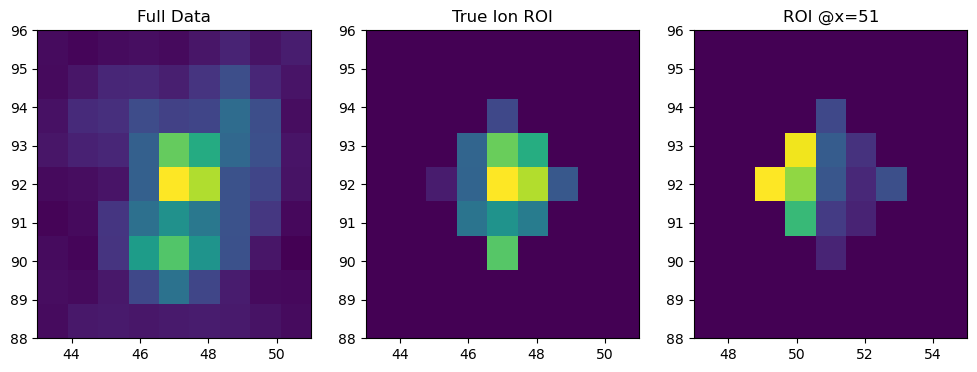

In [4]:
filename='../P/x_389.5'
One(x=47,y=92,x2=51,y2=92,file=filename,plot=True) # x=47; y=92 (Actual Ion)

In [5]:
ion_1=One.ion_1 #ROI of ion centered at x=47

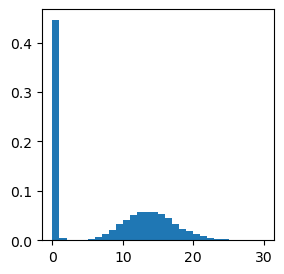

(5, 15.0)

In [6]:
dT=1.5e7  # integration time in ns 
res,guess_1,guess_2=ion_1.GetCountsForEvents(dT)
guess_1,guess_2

Ion 1 
Guess: 1 , 9
min # photons: 3 
 mean counts in bright state = 13.424386805794429 
 mean counts in dark state = 0.0644167139883237


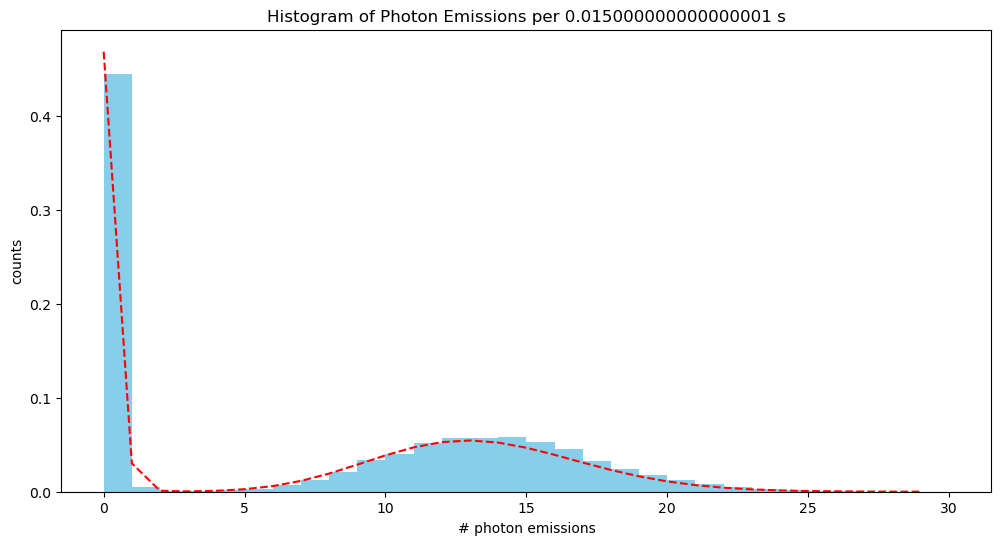

In [7]:
plt.figure(figsize=(12,6))
ion_1.FittingPoisson_double(res, 1, 9)

Max #photons when in dark = 2

Ion 1 ; threshold: 0.0020695970695970697(s)


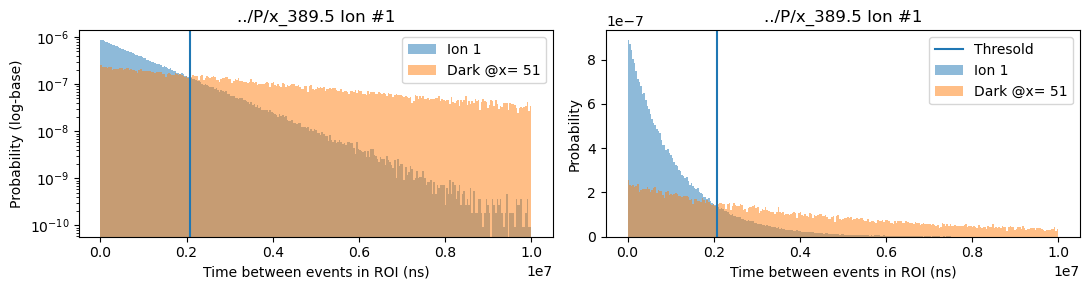

In [8]:
sigma,uncertainty_control,single_photon_control=2,False,True
ion_1.setup("auto",sigma, uncertainty_control, single_photon_control)

In [9]:
data=ion_1.data

In [93]:
k=2 # max dark photons 
temp_BtD=[]   # initializing temporary variable 
for i in ion_1.BtD:
    temp_BtD.append(i)
temp_DtB=[]
for i in ion_1.DtB:
    temp_DtB.append(i)

# This code assumes ion is in bright state at t=0 
to_rem=[]
idx_rem=[]
c=0
for idx,val in enumerate(ion_1.BtD):
    if (val+k-1) < len(data): 
        time_diff=data["time"][val+k-1]-data["time"][val] #time difference of k photons after BtD occurs
        if time_diff<dT:
            to_rem.append(val) 
            temp_BtD.remove(val)
            idx_rem.append(idx)
            #temp_DtB[idx]        #assuming ion starts at bright

    else:
        c+=1 # just here to check code. k=2 => c should be 1 
        time_diff=max(data["time"])-data["time"][val]
        if time_diff<dT:
            to_rem.append(val)
            temp_BtD.remove(val)
            idx_rem.append(idx)
            #temp_DtB[idx]=0
idx_rem.pop()

39377

In [99]:
temp_DtB=np.delete(temp_DtB,idx_rem)

In [102]:
transitions=len(temp_BtD)+len(temp_DtB)
transitions

110

In [105]:
time=(max(One.data_table["time"])-min(One.data_table["time"]))*1e-9
transition_rate=transitions/time
transition_rate

0.18100719868216994

6 seconds--> 1 transition.

In [ ]:
hline_BtD=np.array(data.iloc[temp_BtD]["time"])
hline_DtB=np.array(data.iloc[temp_DtB]["time"])

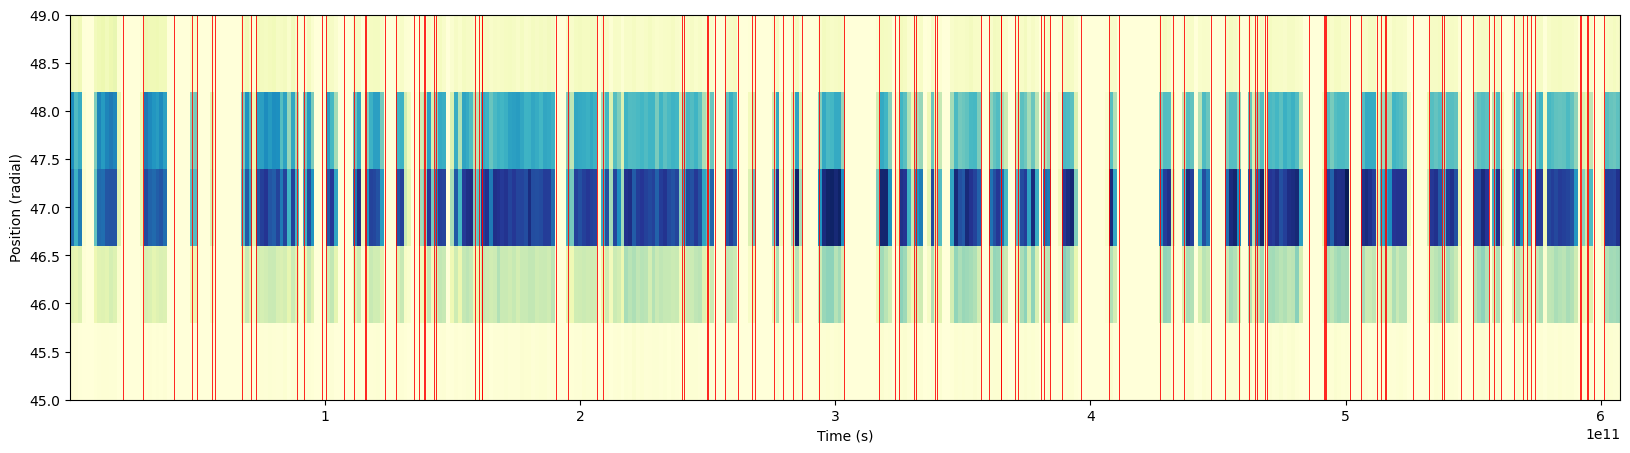

In [175]:
plt.figure(figsize=(20,5))
plt.hist2d(data["time"],data["x"],bins=(400,5),cmap="YlGnBu")
plt.ylabel("Position (radial)")
plt.xlabel("Time (s)")
plt.vlines(hline_BtD,40,60,color="r",lw=0.6)
plt.vlines(hline_DtB,40,60,color="r",lw=0.6)
plt.show()